In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE only: Scaling in n

In [2]:
from jax import random
import jax.numpy as jnp

from numpyro.infer import  Predictive


In [3]:
from reusable.util import get_decoder_params, load_training_history, load_training_state, gen_file_name, load_args
import matplotlib.pyplot as plt
from plotting.plots import plot_training, plot_draws_hpdi
from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE



rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Failed to load a=3200, b=800, 13__3200_35_32_30_0.1_200_0.0001_400_800__RCL+KLD_26
Failed to load a=6400, b=400, 13__6400_35_32_30_0.1_200_0.0001_400_400__RCL+KLD_20
Failed to load a=6400, b=800, 13__6400_35_32_30_0.1_200_0.0001_400_800__RCL+KLD_27


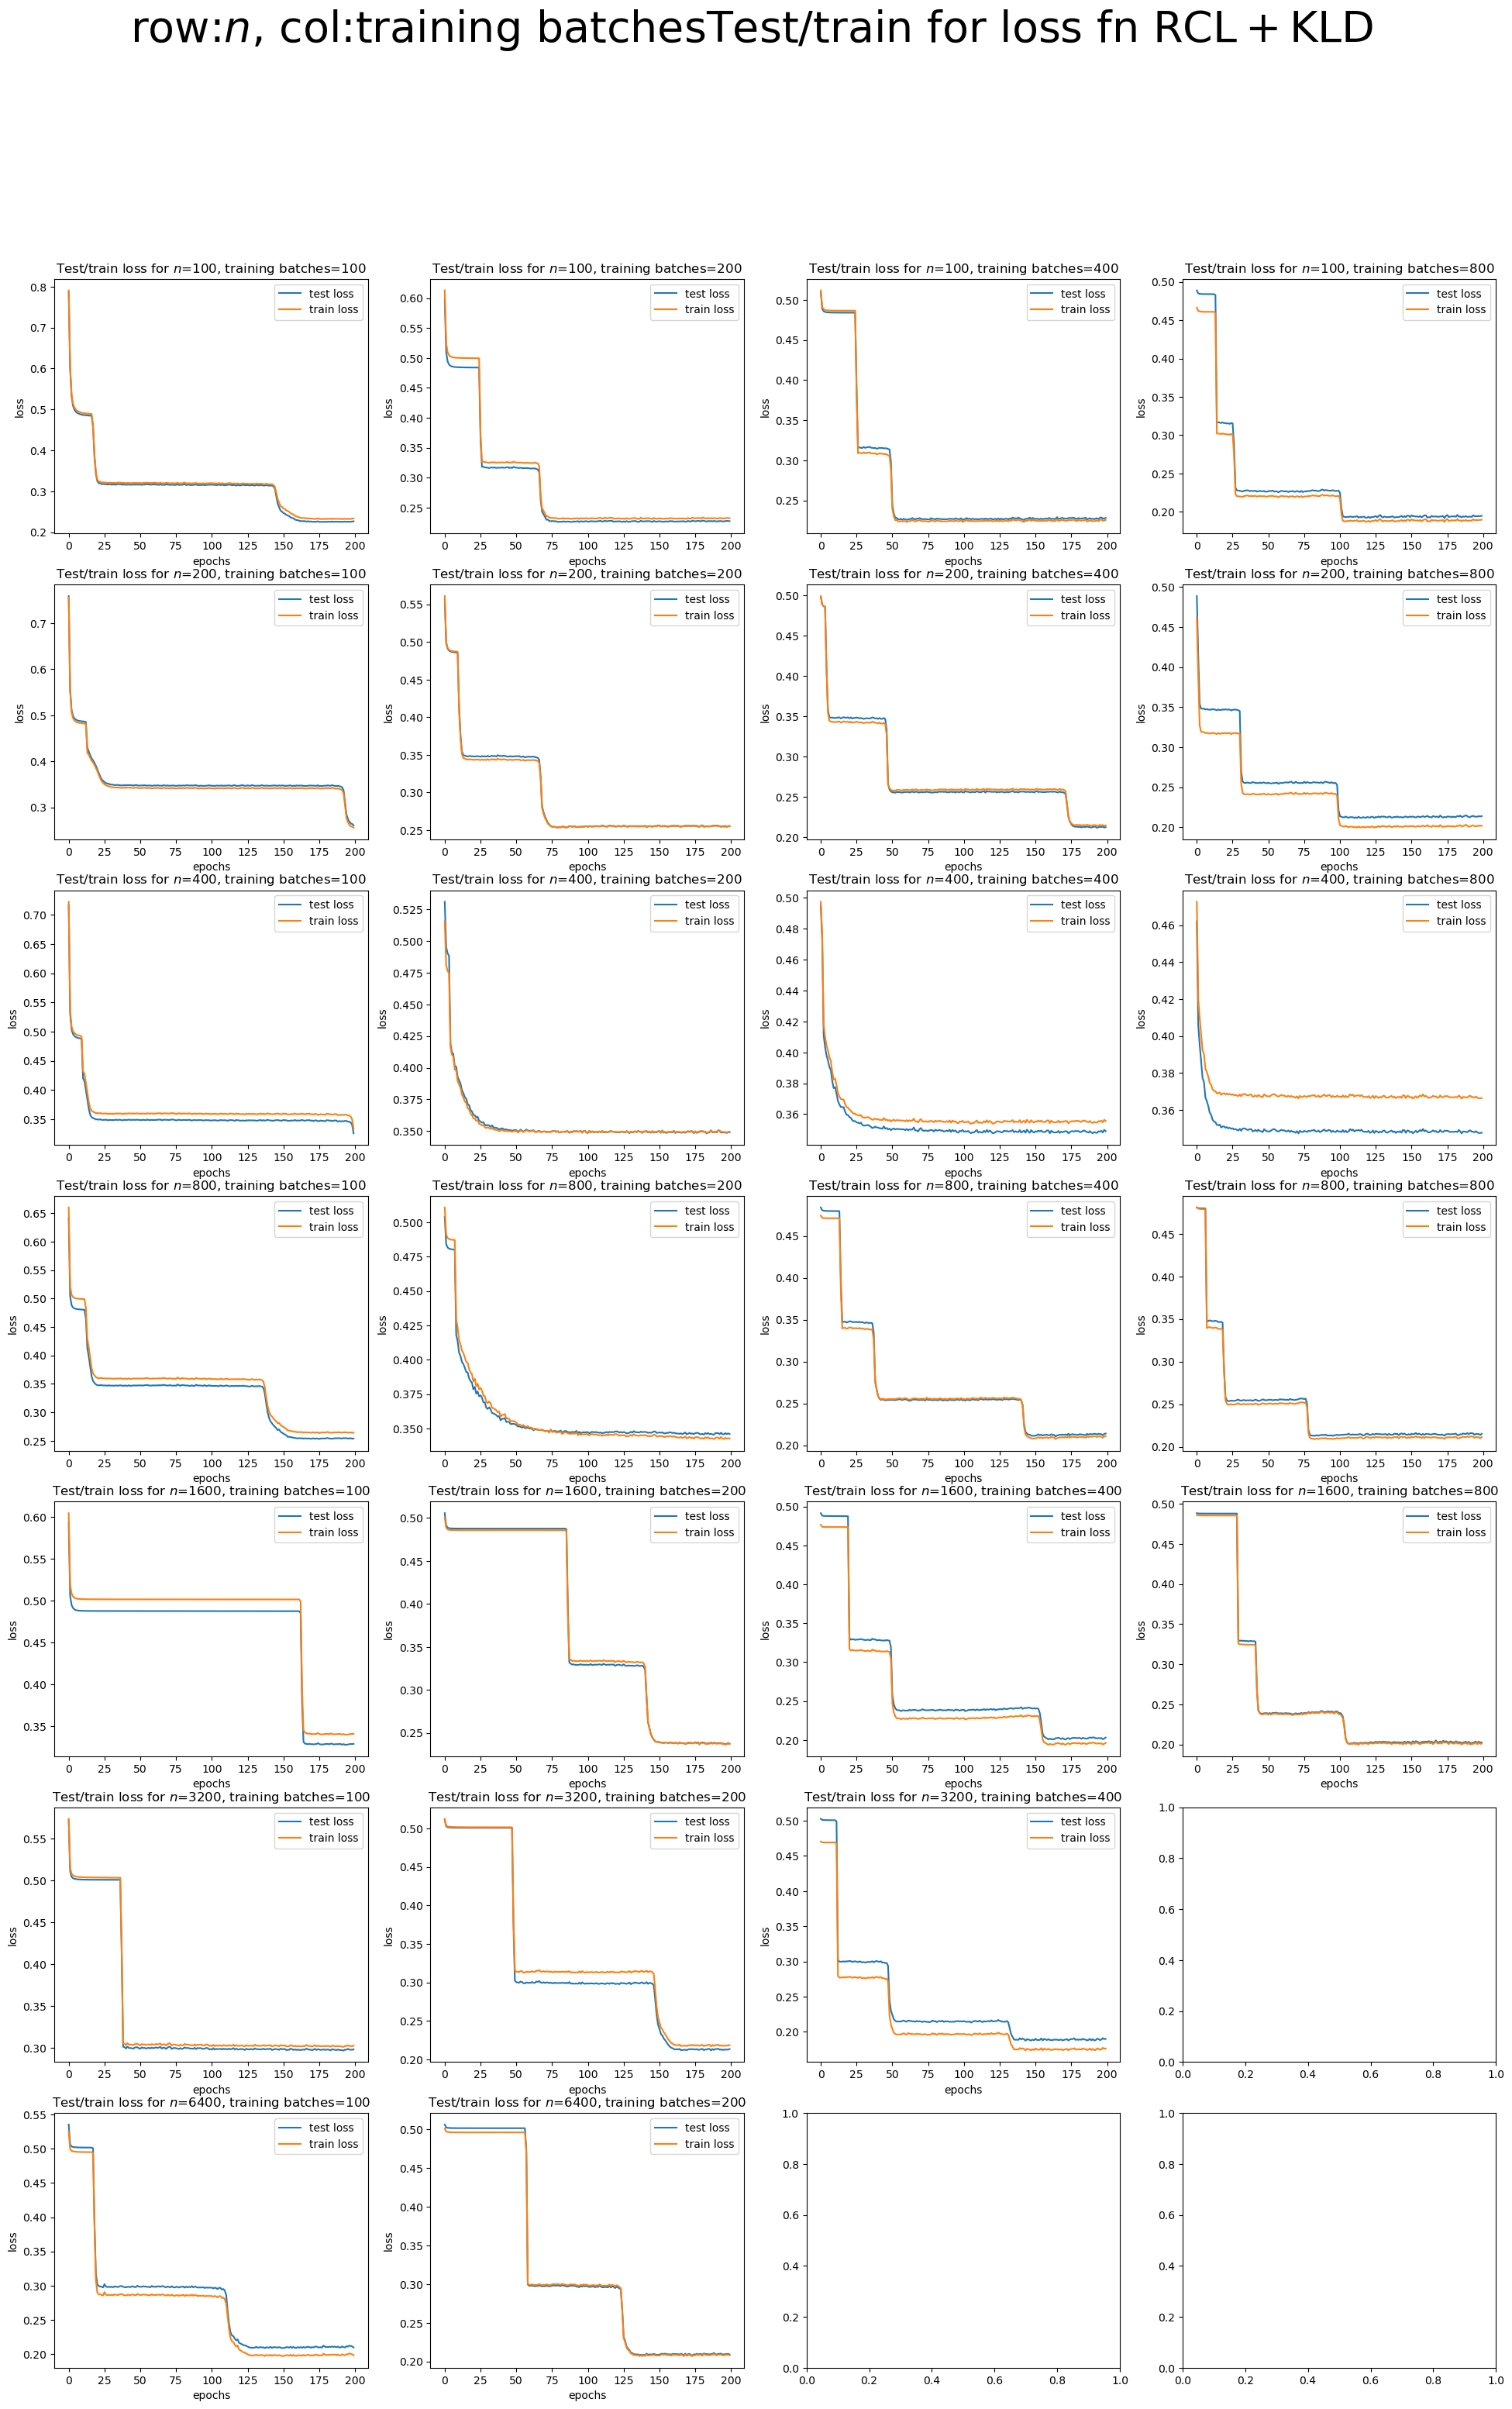

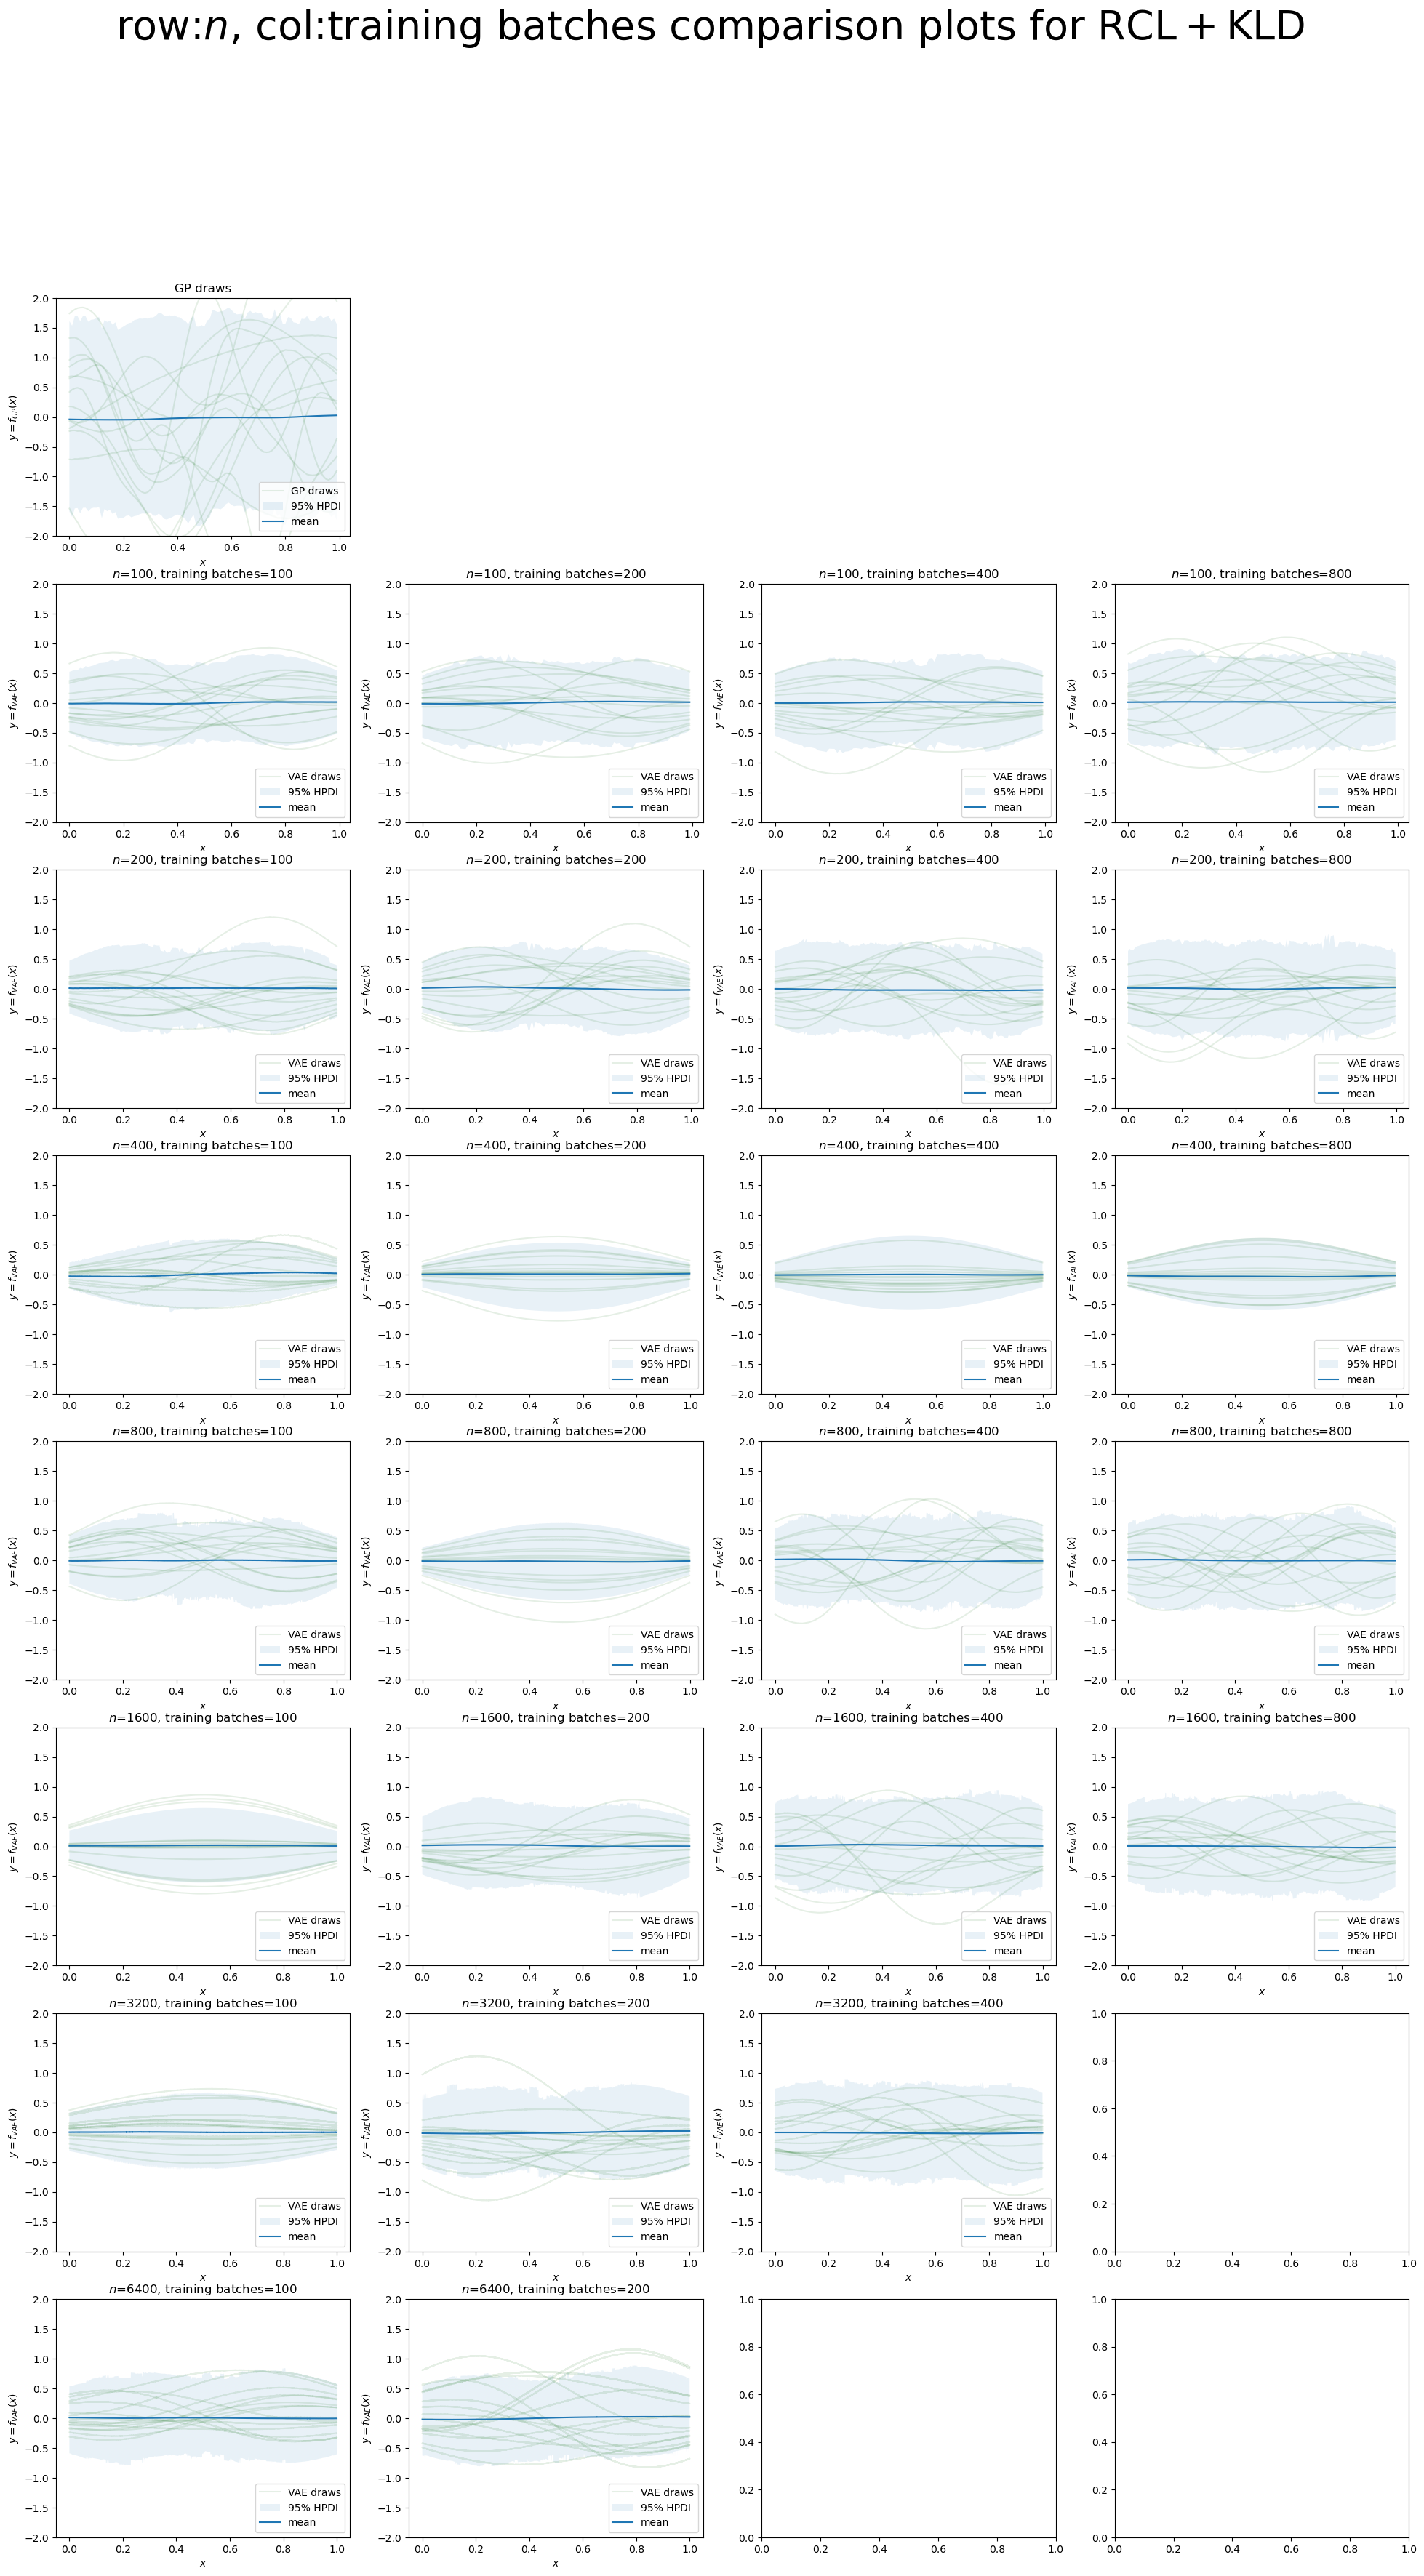

In [4]:
from reusable.util import update_args_11
from plotting.paper import pretty_loss_fn_name, pretty_label

exp_args = load_args("13", "1", "13")

gp_draws = plot_gp_predictive(rng_key_gp, x=exp_args["x"], gp_kernel=exp_args["gp_kernel"], jitter=1e-5)["y"]

aL = len(exp_args["Arange"])
bL = len(exp_args["Brange"])

loss_fn = "RCL+KLD"

pretty_lf = pretty_loss_fn_name(loss_fn)

prettyAdesc = pretty_label(exp_args["Adesc"])
prettyBdesc = pretty_label(exp_args["Bdesc"])


training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
training_fig.suptitle(
    f"row:{prettyAdesc}, col:{prettyBdesc}Test/train for loss fn {pretty_lf}",
    fontsize=40,
)

comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
comp_fig.suptitle(
    f"row:{prettyAdesc}, col:{prettyBdesc} comparison plots for {pretty_lf}",
    fontsize=40,
)

plot_draws_hpdi(gp_draws, exp_args["x"], f"GP draws", "$y=f_{GP}(x)$", "GP", ax=comp_axs[0, 0])

for j in range(1, len(exp_args["Brange"])):
    comp_axs[0, j].remove()

for i, a in enumerate(exp_args["Arange"]):
    for j, b in enumerate(exp_args["Brange"]):
        args = load_args("13", "1", "13")

        args = update_args_11(args, args, i, j)

        index =str( i + j * aL)
        name = f"{loss_fn}_13_{index}"

        filename = gen_file_name("13", args, f"{loss_fn}_{index}")

        try:
            metrics_history = load_training_history("13", filename)

            plot_training(
                metrics_history["test_loss"],
                metrics_history["train_loss"],
                f"Test/train loss for {prettyAdesc}={a}, {prettyBdesc}={b}",
                "loss",
                training_axs[i, j],
            )

            dummy = VAE(
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                conditional=False,
            )
            dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["n"],)))
            decoder_params = get_decoder_params(load_training_state("13",filename, dummy_params))

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=decoder_params,
            )["f"]

            plot_draws_hpdi(
                vae_draws,
                args["x"],
                f"{prettyAdesc}={a}, {prettyBdesc}={b}",
                "$y=f_{VAE}(x)$",
                "VAE",
                ax=comp_axs[i + 1, j],
            )

        except FileNotFoundError:
            print(f"Failed to load a={a}, b={b}, {filename}")


Failed to load a=3200, b=800
Failed to load a=6400, b=400
Failed to load a=6400, b=800


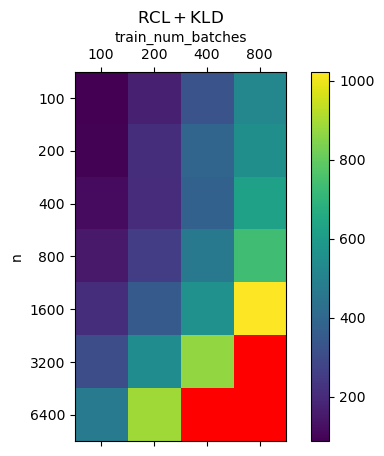

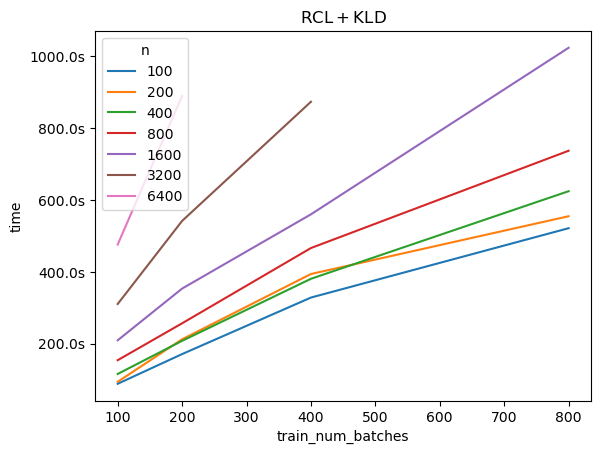

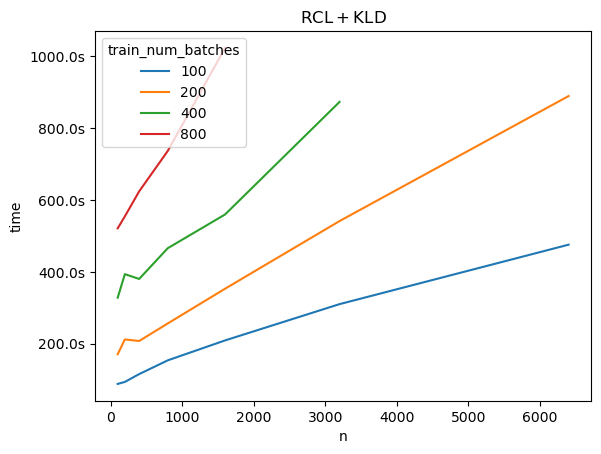

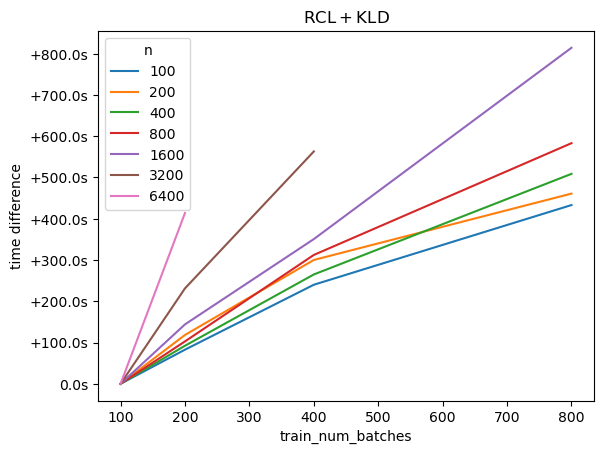

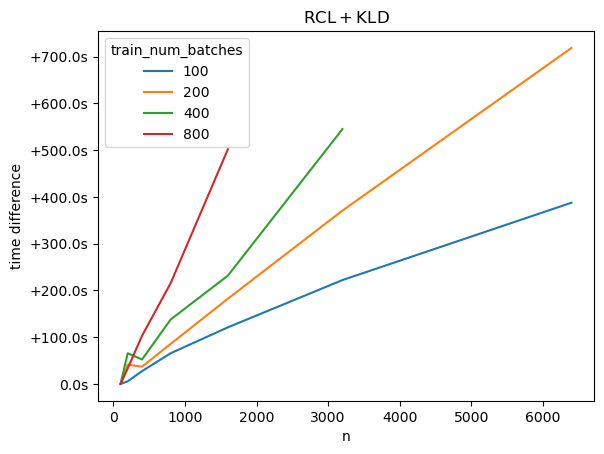

In [6]:
import numpy as onp
from plotting.plots import plot_times_matrix, plot_times_graph


def correct_timing(history, prev_hists):
    """Issue: epoch (and batch times), reset every so often, as I didn't add the times up when rerunning the training"""
    if len(prev_hists) == 0:
        return history

    history["epoch_times"] = history["epoch_times"] + prev_hists[-1]["epoch_times"][-1]
    history["batch_times"] = history["batch_times"] + prev_hists[-1]["epoch_times"][-1]

    return history

aL = len(exp_args["Arange"])
bL = len(exp_args["Brange"])

loss_fn = "RCL+KLD"

pretty_lf = pretty_loss_fn_name(loss_fn)

prettyAdesc = pretty_label(exp_args["Adesc"])
prettyBdesc = pretty_label(exp_args["Bdesc"])
histories = []


for i, a in enumerate(exp_args["Arange"]):
    i_hists = []
    for j, b in enumerate(exp_args["Brange"]):
        args = load_args("13", "1", "13")

        args = update_args_11(args, args, i, j)

        index = str(i + j * aL)
       
     

        try:
            metrics_history = load_training_history("13", gen_file_name("13", args, f"{loss_fn}_{index}"))
            i_hists.append(metrics_history)

        except FileNotFoundError:
            i_hists.append({"interrupted": True})
            print(f"Failed to load a={a}, b={b}")
    histories.append(i_hists)
    
full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories])

interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
full_epochs = onp.array([[len(h["epoch_times"])if "epoch_times" in h else float('nan') for h in hs] for hs in histories])
# matrix of A x B, showing times
plot_times_matrix(
    full_times,
    interrupted,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"{pretty_lf}",
    save_path=f"./gen_plots/13/13_{loss_fn}_matrix.png",
)
# graph of x=A, y=time, curve per B

plot_times_graph(
    full_times,
    exp_args["Brange"],
    exp_args["Arange"],
    exp_args["Bdesc"],
    exp_args["Adesc"],
    f"{pretty_lf}",
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVb.png",
)
# graph of x=B, y=time, curve per B
plot_times_graph(
    full_times.T,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"{pretty_lf}",
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVa.png",
)

# same graphs, but just increase from initial:
initial_times = full_times[:, 0][:, jnp.newaxis]
initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

plot_times_graph(
    full_times - initial_times,
    exp_args["Brange"],
    exp_args["Arange"],
    exp_args["Bdesc"],
    exp_args["Adesc"],
    f"{pretty_lf}",
    is_relative=True,
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVb_change.png",
)

initial_times = full_times.T[:, 0][:, jnp.newaxis]
initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
# graph of x=B, y=time, curve per B
plot_times_graph(
    full_times.T - initial_times,
    exp_args["Arange"],
    exp_args["Brange"],
    exp_args["Adesc"],
    exp_args["Bdesc"],
    f"{pretty_lf}",
    is_relative=True,
    save_path=f"./gen_plots/13/13_{loss_fn}_timeVa_change.png",
)
